<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/CNN-RNN/cnn_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch CNN-RNN https://github.com/ppkgtmm/emotion.git emotion

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, cnn_rnn
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [5]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim', [128, 256])
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
hp.Choice('gru_units', [32, 64])
hp.Fixed('log2_filter', 7)
hp.Fixed('kernel_size', 5)
hp.Fixed('pool_size', 2)
hp.Fixed('activation', 'relu')
seed = 1234

In [6]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
6100,im most afraid of i already feel slightly out ...,anger
10703,i am feeling more like me except a little weepy,sadness
13323,im feeling particularly homesick for my parent...,sadness
532,i am feeling pretty stinkin shitty for being s...,sadness
12861,i feel very uncomfortable around people with d...,fear


In [7]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [8]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [9]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [10]:
tuner = BayesianOptimization( cnn_rnn.build_model,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/cnn_rnn_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           20512     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 128)           0

In [11]:
history = tuner.search(
            sequence_train, target_train,
            validation_split=0.1,
            epochs=3)

Trial 12 Complete [00h 02m 33s]
val_accuracy: 0.9141176640987396

Best val_accuracy So Far: 0.9161764681339264
Total elapsed time: 00h 41m 27s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
output_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}
gru_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
log2_filter (Fixed)
{'conditions': [], 'value': 7}
kernel_size (Fixed)
{'conditions': [], 'value': 5}
pool_size (Fixed)
{'conditions': [], 'value': 2}
activation (Fixed)
{'conditions': [], 'value': 'relu'}


In [13]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/cnn_rnn_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
max_len: 300
num_words: 15000
gru_units: 32
log2_filter: 7
kernel_size: 5
pool_size: 2
activation: relu
Score: 0.9161764681339264
Trial summary
Hyperparameters:
output_dim: 128
optimizer: adam
max_len: 300
num_words: 15000
gru_units: 32
log2_filter: 7
kernel_size: 5
pool_size: 2
activation: relu
Score: 0.9144117534160614
Trial summary
Hyperparameters:
output_dim: 128
optimizer: adam
max_len: 300
num_words: 15000
gru_units: 32
log2_filter: 7
kernel_size: 5
pool_size: 2
activation: relu
Score: 0.9141176640987396


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           40992     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 128)           0

94/94 [==============================] - 2s 13ms/step
Accuracy:	90.0%


              precision    recall  f1-score   support

       anger       0.87      0.87      0.87       406
        fear       0.85      0.89      0.87       356
         joy       0.90      0.95      0.92      1014
        love       0.85      0.70      0.77       246
     sadness       0.95      0.96      0.96       870
    surprise       0.86      0.57      0.69       108

    accuracy                           0.90      3000
   macro avg       0.88      0.82      0.85      3000
weighted avg       0.90      0.90      0.90      3000



<Figure size 432x288 with 0 Axes>

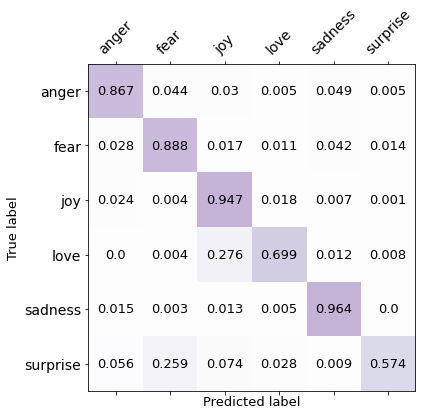

In [15]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [16]:
model = cnn_rnn.build_model(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          3840000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 32)           40992     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 34, 128)          

In [17]:
cb = utils.get_callbacks("cnn_rnn.h5")

In [18]:
history = model.fit(sequence_train, target_train, validation_split=0.1,
            epochs=100, callbacks=cb)

Epoch 1/100
479/479 [==============================] - 43s 82ms/step - loss: 1.4797 - accuracy: 0.3976 - precision_1: 0.5518 - recall_1: 0.1029 - val_loss: 0.9695 - val_accuracy: 0.6271 - val_precision_1: 0.6683 - val_recall_1: 0.5771

Epoch 00001: val_accuracy improved from -inf to 0.62706, saving model to cnn_rnn.h5
Epoch 2/100
479/479 [==============================] - 38s 79ms/step - loss: 0.8246 - accuracy: 0.6842 - precision_1: 0.7580 - recall_1: 0.5745 - val_loss: 0.3631 - val_accuracy: 0.8959 - val_precision_1: 0.9096 - val_recall_1: 0.8824

Epoch 00002: val_accuracy improved from 0.62706 to 0.89588, saving model to cnn_rnn.h5
Epoch 3/100
479/479 [==============================] - 37s 78ms/step - loss: 0.2562 - accuracy: 0.9218 - precision_1: 0.9315 - recall_1: 0.9140 - val_loss: 0.2683 - val_accuracy: 0.9188 - val_precision_1: 0.9251 - val_recall_1: 0.9088

Epoch 00003: val_accuracy improved from 0.89588 to 0.91882, saving model to cnn_rnn.h5
Epoch 4/100
479/479 [=============

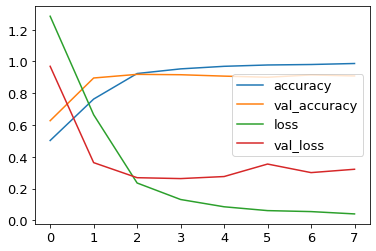

In [19]:
metr = ['accuracy','val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

94/94 [==============================] - 2s 12ms/step
Accuracy:	89.9%


              precision    recall  f1-score   support

       anger       0.91      0.79      0.84       406
        fear       0.85      0.91      0.88       356
         joy       0.95      0.91      0.93      1014
        love       0.74      0.86      0.80       246
     sadness       0.92      0.98      0.95       870
    surprise       0.84      0.61      0.71       108

    accuracy                           0.90      3000
   macro avg       0.87      0.84      0.85      3000
weighted avg       0.90      0.90      0.90      3000



<Figure size 432x288 with 0 Axes>

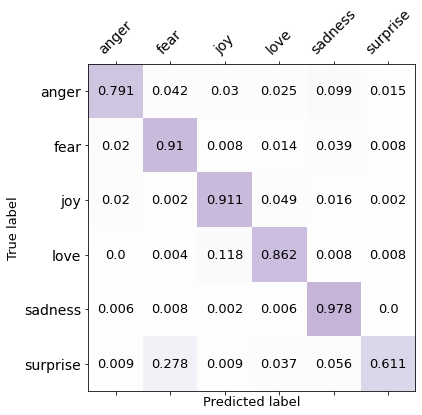

In [20]:
utils.model_evaluate(model, sequence_test, target_test, 32)

In [22]:
# utils.dump(tokenizer,'/content/drive/MyDrive/__ed__/cnn_rnn_B32/tokenizer.pickle')
# utils.dump(history.history,'/content/drive/MyDrive/__ed__/cnn_rnn_B32/history.pickle')

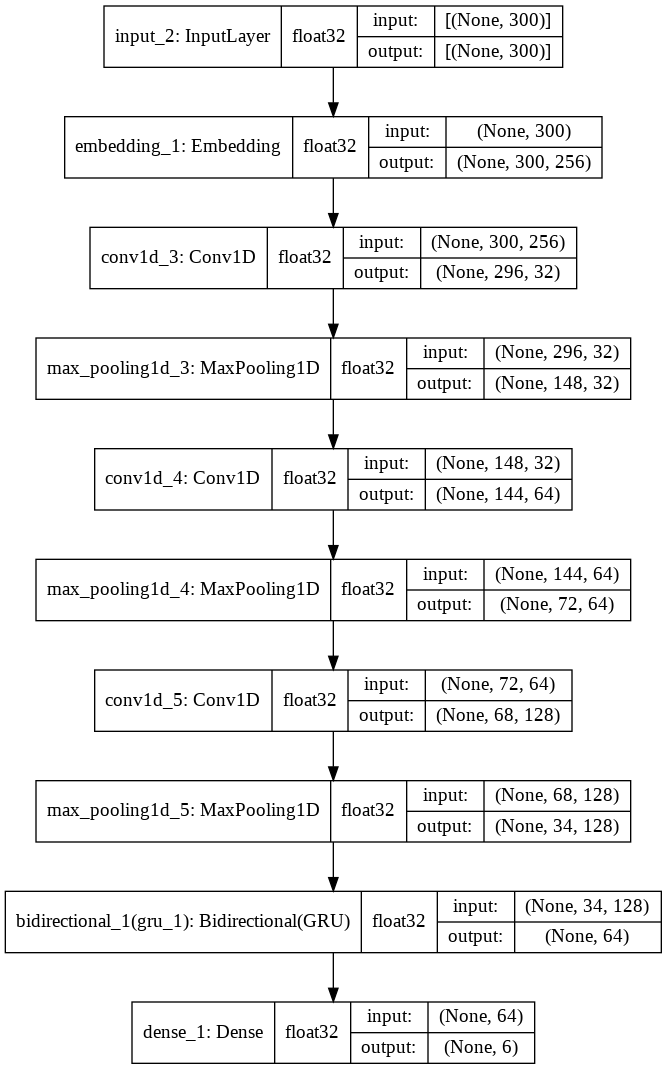

In [23]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='/content/drive/MyDrive/__ed__/cnn_rnn_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )